# To-do list
##Implement latent variable model <br>
replace the value of f by f* where f* is drawn from a distrubtion that uses f as the basis for the prior. 
##Add noise to data and try fit 
I need to think of a smater way to add my error, HalfCauchy is just a bit bashful. If we know that there is an error of x, y, z on measurements a, b, c how can this correlate to the noise in the GP function.<br>
I should also take into account that the error is gonna be like +/- 10% and therefore should use this to inform my noise function.
# To look into list
Hierarchical model <br>
Varitational inference <br>
Different samplers - HMC <br>


In [1]:
!pip install pymc3 --upgrade  # This must be called every first run
!pip install PyAstronomy

Requirement already up-to-date: pymc3 in /usr/local/lib/python3.6/dist-packages (3.10.0)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pymc3 as pm
import theano as tt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib  import cm
from PyAstronomy import pyasl

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
##### OPTIONS #####

map = 1       # 1 - use find map, 0 - sample 
samples = 600  #if sampling, this is the number that decides the sampling and tuning
tune = 600

opt_params = 0   # if 1 use predetermined values

errorbars = 0   # plot error bars on surface plot 
smp_rt = 1     # every nth point of true data
num_gen = 400 # given n will produce n x n points of predictions

var_inf = False



data = np.genfromtxt('/content/drive/My Drive/data/data2.csv', delimiter=',', skip_header=1)
#!pip install pymc3 --upgrade  # This must be called every first run

Teff = data[:,1][0::smp_rt] # Teff
Prot = data[:, 2][0::smp_rt]  # Prot
Age = data[:, 3][0::smp_rt]  # Age 
Mass = data[:, 4][0::smp_rt]   # mass
b = pyasl.BallesterosBV_T()

#data 1 and data 2 have differnet columns! 

## Here is where I am adding some noise to the data roughly 5% for mass prot and Teff, 10% for Age

data_noise = True
n_age = 0.2
n_oth = 0.04
if data_noise:

  Age_err = (np.random.normal( 0, Age  * n_age , Age.shape))
  Teff_err = (np.random.normal( 0, Teff * n_oth , Teff.shape))
  Prot_err = (np.random.normal( 0, abs(Prot) * n_oth , Prot.shape))
  Mass_err = (np.random.normal( 0, Mass * n_oth , Mass.shape))

  Age  += Age_err
 # Teff += Teff_err
  Prot += Prot_err 
  Mass += Mass_err


BV =  b.bv2T(np.array(Teff))

In [4]:
def mean_fn(Age, Mass, BV, A, c, d, h, f):
  return A * Age**c * Mass**d * (BV-h)**f


# Age 

[12.6329408   0.38477705]


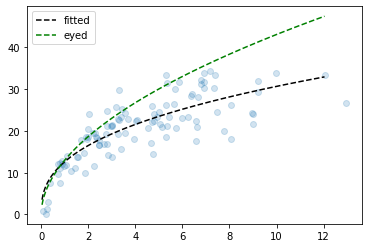

In [5]:


limit = (np.where(np.logical_and(Mass>0.9, Mass<=0.94)))

Teff_short = Teff[limit]
Prot_short = Prot[limit]
Age_short = Age[limit]
Mass_short = Mass[limit]

Age_short += np.random.normal( 0, Age_short/10 , Age_short.shape)
# might add some error? Could be fun to see what
plt.scatter(Age_short, Prot_short, alpha=0.2)



coefs = scipy.optimize.curve_fit(lambda t,a,c: a*t**c,  Age_short,  Prot_short, p0=(10,0.5))
print(coefs[0])

x = np.linspace(np.amin(Age),np.amax(Age),1000)
y1 = coefs[0][0]* x **coefs[0][1]
y2 = 13*x**0.52
plt.plot(x,y1, color='k', linestyle='--', label='fitted')
plt.plot(x,y2, color='g', linestyle='--', label='eyed')
plt.legend()



In [6]:
A = coefs[0][0]
c = coefs[0][1]
X = np.array([Age, Mass]).T 

with pm.Model() as model:

    A_ = pm.Normal('A_', A, A*0.5)
    c_ = pm.Normal('c_', c, c*0.3)
    mean = A_ * Age**c_

    l1 = pm.Lognormal('l1', mu=np.log(14.0), sigma=0.01)  # 1
    l2 = pm.Lognormal('l2', mu=np.log(0.1), sigma=0.01)
    
    resid = Prot - mean

    sf2 = pm.Lognormal("sf2", mu=np.log(15), sigma=1)
    sf1 = pm.Lognormal("sf1", mu=np.log(15), sigma=1)
    

    K1 = pm.gp.cov.ExpQuad(2, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(2, l2) * sf2**2
    K = K1 * K2

    gp = pm.gp.Marginal(cov_func=K)
    obs = gp.marginal_likelihood("obs", X=X, y=resid, noise=1.0)

    mp = pm.find_MAP()


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


{'A_': array(10.78289491), 'c_': array(0.41813938), 'l1_log__': array(2.63894636), 'l2_log__': array(-2.63165134), 'sf2_log__': array(1.65533158), 'sf1_log__': array(1.65533158), 'l1': array(13.99844652), 'l2': array(0.07195953), 'sf2': array(5.2348154), 'sf1': array(5.2348154)}


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


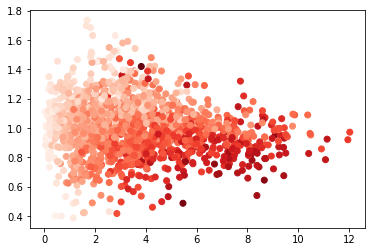

10.78289491125724 0.41813938152753943


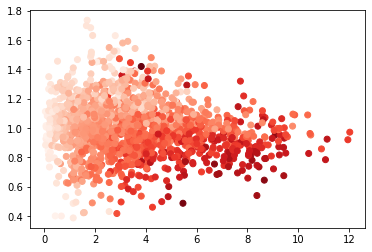

In [7]:
print(mp)
A = mp['A_']
c = mp['c_']

age_new = np.random.rand(400) * 8
mass_new = np.random.rand(400) * 1.0 + 0.4
Xnew = np.array([age_new, mass_new]).T
mu, var = gp.predict(X, point=mp, diag=True, pred_noise=True)




plt.scatter(Age, Mass, c=Prot, cmap='Reds')
plt.show()
plt.scatter(Age, Mass, c = mp['A_'] * Age**mp['c_'] + mu, cmap='Reds')

print(A, c)




[19.54515693 -0.97994558]


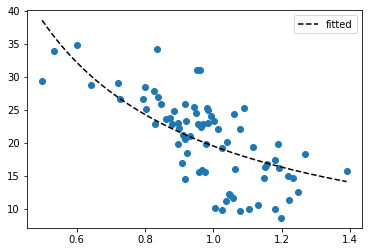

In [8]:
limit = (np.where(np.logical_and(Age>4.4, Age<=5)))


Teff_short = Teff[limit]
Prot_short = Prot[limit]
Age_short = Age[limit]
Mass_short = Mass[limit]


plt.scatter(Mass_short, Prot_short)


coefs2 = scipy.optimize.curve_fit(lambda t,a,c: a*t**c,  Mass_short,  Prot_short)
print(coefs2[0])

x = np.linspace(np.amin(Mass_short),np.amax(Mass_short),1000)
y1 = coefs2[0][0]* x **coefs2[0][1]

plt.plot(x,y1, color='k', linestyle='--', label='fitted')
plt.legend()





-0.9799455834191343


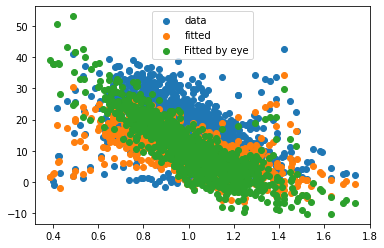

{'B_': array(19.17209144), 'd__interval__': array(3.16319556), 'l1_log__': array(1.27265095), 'l2_log__': array(-0.72141377), 'sf2_log__': array(1.16472118), 'sf1_log__': array(1.16472096), 'n_log__': array(1.42736577), 'd_': array(-0.04916262), 'l1': array(3.57030473), 'l2': array(0.48606459), 'sf2': array(3.20502912), 'sf1': array(3.20502842), 'n': array(4.16770604)}


In [9]:
B = coefs2[0][0]
d = coefs2[0][1]
X = np.array([Age, Mass]).T 

print(d)

with pm.Model() as model:

    B_= pm.Normal('B_', B, B*0.5)
    d_ = pm.Uniform('d_', d, d*0.01)

    mean =  B_ *Mass**d_

    resid = Prot - mean


    l1 = pm.Lognormal('l1', mu=np.log(3.6), sigma=0.11)  # 1
    l2 = pm.Lognormal('l2', mu=np.log(0.4), sigma=0.11)
  
    sf2 = pm.Lognormal("sf2", mu=np.log(160), sigma=1)
    sf1 = pm.Lognormal("sf1", mu=np.log(160), sigma=1)

    K1 = pm.gp.cov.ExpQuad(2, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(2, l2) * sf2**2
    
    K = K1 * K2


    n = pm.HalfCauchy("n", beta=5)

    gp = pm.gp.Marginal(cov_func=K)
    obs = gp.marginal_likelihood("obs", X=X, y=resid, noise=n)
    
    mp = pm.find_MAP()

plt.scatter(Mass, Prot, label='data')
plt.scatter(Mass, A* Mass**mp['d_'] + mu, label='fitted')
plt.scatter(Mass, A* Mass**-1.6 + mu, label='Fitted by eye')
plt.legend()
plt.show()
print(mp)


The best fit value for d here does not fit the model very well. I do not like it. <br>The value determined through the linear regresssion fits far better, therefore I will be using that value going forward. 

https://iopscience.iop.org/article/10.1088/0004-637X/695/1/679/pdf
In this article a form is given to determine P from Bv and age that is of a slightly sifferent form to what I am currently using.
$P(t, B-V) = t^{0.52} g(B-V -h)^f$ <br>
where $g=0.77, h=0.4, f = 0.6$. I will now construct another GP using this as the mean function and see how it goes.

Im gonna sort of bash the BV dependance onto the end of my current mass, age mean function and see how it goes B). The new mean function will look like $P(t,m,(B-V)) = At^cm^d((B-V)-h)^f$. Where I a taking d from the previous GP, here A is going to be allowed to vary and the starting value will be $A^{\star}g$, where $A^{\star}$ is the A from before.  

This has resulted in considerably better results.


In [18]:
#### book ####
g = 0.77
h = 0.4 
f = 0.6 
c=0.52 

#determined 
d = d 
A = A 


K_b = b.bv2T(np.array(6200)) #  Kraft break

#limit = (np.where(BV<K_b))


#limit = (np.where(BV>0))
limit = np.where((Prot>0))
## big test time 

BV_short = BV[limit]
Prot_short = Prot[limit]
Age_short = Age[limit]
Mass_short = Mass[limit]
X = np.array([Age_short, Mass_short, BV_short]).T 



with pm.Model() as model:

    f_ = pm.Normal('f_', f, f*0.5)
    A_ = pm.Normal('A_', A*g, A*0.3)



  
    Age_true = pm.Uniform("Age_true", 0.01, 14, shape=Age_short.shape)
    Age_obs = pm.Normal("Age_obs", Age_true, Age_short*n_age, observed=Age_short)

    Mass_true = pm.Uniform("Mass_true", min(Mass_short), max(Mass_short), shape=Mass_short.shape)
    Mass_obs = pm.Normal("Mass_obs", Mass_true, Mass_short*n_oth, observed=Mass_short)

    #BV_true = pm.Uniform("BV_True", min(BV_short), max(BV_short), shape=BV_short.shape)
    #BV_obs = pm.Normal("BV_obs", BV_true, BV_short*n_oth, observed=BV_short)





    mean = A_* Age_true**c   * Mass_true **d  * (BV_short - h)**f_
    resid = Prot_short - mean

    l1 = pm.Lognormal('l1', mu=np.log(14.0), sigma=0.11)  # 1
    l2 = pm.Lognormal('l2', mu=np.log(3.6), sigma=0.11)
    l3 = pm.Lognormal('l3', mu=np.log(4), sigma=0.5)

    sf1 = pm.Lognormal("sf1", mu=np.log(15), sigma=5)
    sf2 = pm.Lognormal("sf2", mu=np.log(40), sigma=15)
    sf3 = pm.Lognormal('sf3', mu=np.log(45), sigma=10)

    K1 = pm.gp.cov.ExpQuad(3, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(3, l2) * sf2**2
    K3 = pm.gp.cov.ExpQuad(3, l3) * sf3**2

    K = K1 * K2 * K3
    
    gp = pm.gp.Marginal(cov_func=K)
    x = tt.tensor.stack([Age_true, Mass_true, BV_short])

    obs = gp.marginal_likelihood("obs", X=x.T , y=resid, noise=n_oth)

    #if not var_inf:
    mp = pm.find_MAP()
     
    

/usr/local/lib/python3.6/dist-packages/pymc3/gp/cov.py:97: UserWarning: Only 3 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  UserWarning,


/usr/local/lib/python3.6/dist-packages/pymc3/gp/cov.py:97: UserWarning: Only 3 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  UserWarning,


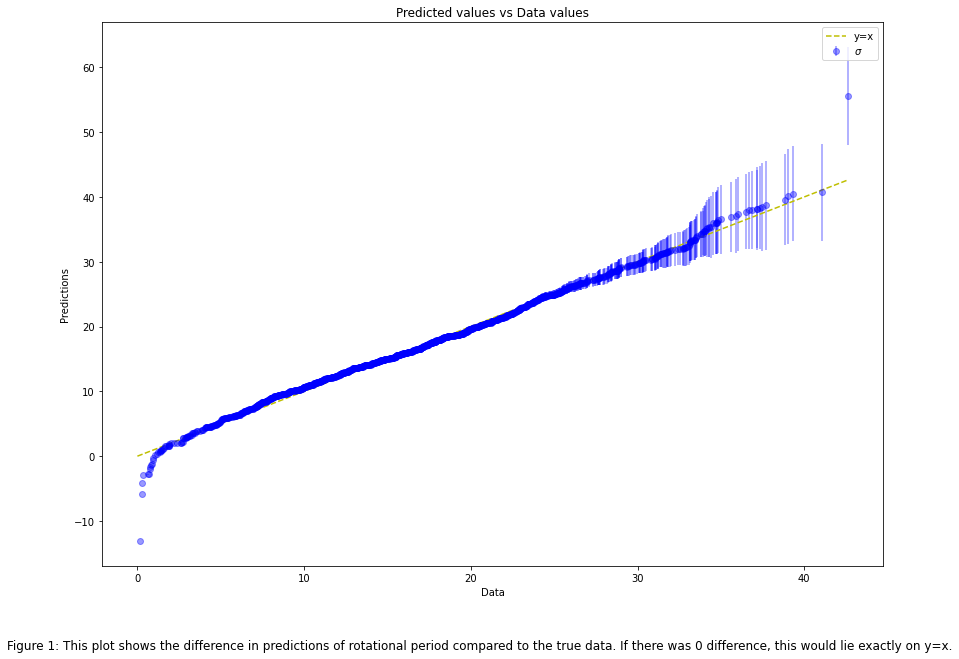

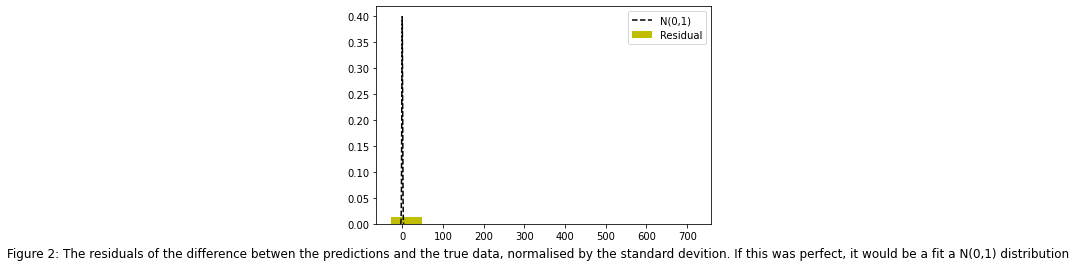

In [19]:
mu, var = gp.predict(X, point=mp, diag=True, pred_noise=False)
sd = np.sqrt(var)

mean = mp['A_'] *Age**c   * Mass **d  * (BV - h)**mp['f_']

ydata = Prot
num_gen = len(Mass)
numElems = len(mu)

idx = np.round(np.linspace(0, len(mean) - 1, numElems)).astype(int)
# Picks equal spaced elements from (longer) prediction array so that its shape of data


mu_test = mean[idx] + mu
sd_test = sd


vals = np.sort([mu_test, sd_test], axis=1)

# sorts them together :) 

fig = plt.figure(figsize=(14, 10))

plt.plot([0, max(Prot)], [0, max(Prot)], linestyle='--', label='y=x', color='y')
plt.errorbar(np.sort(Prot_short), vals[0,:], yerr=vals[1,:], fmt='o', label=r'$\sigma$', color='b', alpha=0.4)


plt.xlabel("Data")
plt.ylabel("Predictions")
plt.title("Predicted values vs Data values")

txt="Figure 1: This plot shows the difference in predictions of rotational period compared to the true data. If there was 0 difference, this would lie exactly on y=x."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.legend()
plt.show()

Z = (np.sort(Prot_short) - vals[0, :])/(vals[1, :])



x = np.linspace(-5,5, 1000)
f = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * x**2) #N(0,1) to compare with Z 

plt.hist(Z, density=True, label='Residual', color='y')
 
plt.plot(x,f, label='N(0,1)', color='k', linestyle='--')
txt="Figure 2: The residuals of the difference betwen the predictions and the true data, normalised by the standard devition. If this was perfect, it would be a fit a N(0,1) distribution"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.legend()
plt.show()

In [12]:
print(sd_test)

[0.40075516 0.10243165 0.13829372 ... 0.04692425 0.02571111 0.77829488]


These two plots are evidence that this model does fit the data very well. We can use the parameters and hyper parameters gathered here for future GP implementations on true data. 

In [13]:
### TESTING latent variable 
'''
# vars = A,c, d, f
g = 0.77
h = 0.4
f = 0.6
X = np.array([Age, Mass, BV]).T 
K_b = b.bv2T(np.array(6200)) #  Kraft break

limit = (np.where(BV>K_b))

limit = (np.where(BV>0))


X = np.array([Age_short, Mass_short, BV_short]).T 

with pm.Model() as latent_gp_model:




    l1 = pm.Lognormal('l1', mu=np.log(14.0), sigma=0.11)  # 1
    l2 = pm.Lognormal('l2', mu=np.log(3.6), sigma=0.11)
    l3 = pm.Lognormal('l3', mu=np.log(4), sigma=0.5)

    sf1 = pm.Lognormal("sf1", mu=np.log(15), sigma=5)
    sf2 = pm.Lognormal("sf2", mu=np.log(40), sigma=15)
    sf3 = pm.Lognormal('sf3', mu=np.log(45), sigma=10)

    K1 = pm.gp.cov.ExpQuad(3, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(3, l2) * sf2**2
    K3 = pm.gp.cov.ExpQuad(3, l3) * sf3**2

    K = K1 * K2 * K3


        
    resid = Prot_short - mean
    n = 1

    gp = pm.gp.Latent(cov_func=K)




with latent_gp_model:
  ## for now just making predictions on f and A
    f = gp.prior("f", X=X)
    f_ = pm.Normal('f_', f, f*0.5)
    A_ = pm.Normal('A_', A*g, A*0.3)
  
    mean = A_* Age_short**c   * Mass_short **d  * (BV_short - h)**f_
    '''

'\n# vars = A,c, d, f\ng = 0.77\nh = 0.4\nf = 0.6\nX = np.array([Age, Mass, BV]).T \nK_b = b.bv2T(np.array(6200)) #  Kraft break\n\nlimit = (np.where(BV>K_b))\n\nlimit = (np.where(BV>0))\n\n\nX = np.array([Age_short, Mass_short, BV_short]).T \n\nwith pm.Model() as latent_gp_model:\n\n\n\n\n    l1 = pm.Lognormal(\'l1\', mu=np.log(14.0), sigma=0.11)  # 1\n    l2 = pm.Lognormal(\'l2\', mu=np.log(3.6), sigma=0.11)\n    l3 = pm.Lognormal(\'l3\', mu=np.log(4), sigma=0.5)\n\n    sf1 = pm.Lognormal("sf1", mu=np.log(15), sigma=5)\n    sf2 = pm.Lognormal("sf2", mu=np.log(40), sigma=15)\n    sf3 = pm.Lognormal(\'sf3\', mu=np.log(45), sigma=10)\n\n    K1 = pm.gp.cov.ExpQuad(3, l1) * sf1**2\n    K2 = pm.gp.cov.ExpQuad(3, l2) * sf2**2\n    K3 = pm.gp.cov.ExpQuad(3, l3) * sf3**2\n\n    K = K1 * K2 * K3\n\n\n        \n    resid = Prot_short - mean\n    n = 1\n\n    gp = pm.gp.Latent(cov_func=K)\n\n\n\n\nwith latent_gp_model:\n  ## for now just making predictions on f and A\n    f = gp.prior("f", X=X)\

In [14]:
'''n = 200  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
σ_true = 2.0
ν_true = 3.0
y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")
ax.set_xlabel("X")
ax.set_ylabel("y")
plt.legend();

'''

'n = 200  # The number of data points\nX = np.linspace(0, 10, n)[:, None]  # The inputs to the GP must be arranged as a column vector\n\n# Define the true covariance function and its parameters\nℓ_true = 1.0\nη_true = 3.0\ncov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)\n\n# A mean function that is zero everywhere\nmean_func = pm.gp.mean.Zero()\n\n# The latent function values are one sample from a multivariate normal\n# Note that we have to call `eval()` because PyMC3 built on top of Theano\nf_true = np.random.multivariate_normal(\n    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1\n).flatten()\n\n# The observed data is the latent function plus a small amount of T distributed noise\n# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`\nσ_true = 2.0\nν_true = 3.0\ny = f_true + σ_true * np.random.standard_t(ν_true, size=n)\n\n## Plot the data and the unobserved latent function\nfig = plt.figure(figsize=(12, 5))\nax = fig.gca()\nax.plo

In [15]:
'''with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=1)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0 / σ, nu=ν, observed=y)

    trace = pm.sample(1000, chains=2, cores=1, return_inferencedata=True)

'''

'with pm.Model() as model:\n    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)\n    η = pm.HalfCauchy("η", beta=1)\n\n    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)\n    gp = pm.gp.Latent(cov_func=cov)\n\n    f = gp.prior("f", X=X)\n\n    σ = pm.HalfCauchy("σ", beta=5)\n    ν = pm.Gamma("ν", alpha=2, beta=0.1)\n    y_ = pm.StudentT("y", mu=f, lam=1.0 / σ, nu=ν, observed=y)\n\n    trace = pm.sample(1000, chains=2, cores=1, return_inferencedata=True)\n\n'

In [16]:
# 200 new values from x=0 to x=15
'''
n_new = 200
X_new = np.linspace(0, 15, n_new)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace.posterior, vars=[f_pred])'''

'\nn_new = 200\nX_new = np.linspace(0, 15, n_new)[:, None]\n\n# add the GP conditional to the model, given the new X values\nwith model:\n    f_pred = gp.conditional("f_pred", X_new)\n\n# Sample from the GP conditional distribution\nwith model:\n    pred_samples = pm.sample_posterior_predictive(trace.posterior, vars=[f_pred])'

In [17]:
'''fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new)

ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

ax.set_xlabel("X")
ax.set_ylabel("True f(x)")
ax.set_title("Conditional distribution of f_*, given f")
plt.legend();'''

'fig = plt.figure(figsize=(12, 5))\nax = fig.gca()\nplot_gp_dist(ax, pred_samples["f_pred"], X_new)\n\nax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function \'f\'")\nax.plot(X, y, "ok", ms=3, label="Observed data")\n\nax.set_xlabel("X")\nax.set_ylabel("True f(x)")\nax.set_title("Conditional distribution of f_*, given f")\nplt.legend();'

Second fast component t the gp when we dont have B-V